In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from random import randint
import scipy.stats as st
from scipy.signal import correlate2d
import collections
%matplotlib inline

In [9]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

class Graph:
    '''Class used for dijsktra'''
    def __init__(self):
        #More efficient containers than arrays for this task
        self.nodes = set()
        self.edges = collections.defaultdict(list)
        self.distances = {}

    def add_node(self, value):
        self.nodes.add(value)

    def add_edge(self, from_node, to_node, distance):
        self.edges[from_node].append(to_node)
        self.edges[to_node].append(from_node)
        self.distances[(from_node, to_node)] = distance
    
    def Matrix2Graph(self,Matrix):
        '''Transforms a 2D matrix (np array) into a graph the implementation of shortest path 
        I used does was not made for undirected graphs so each vertex is added twice
        The adjacency is defined with a 8-Neighborhood'''
        '''Weights are the error of the destination pixel'''
        '''2 nodes are added, one for the 1st row and 1 for the last row, going and getting has no weight,
        this nodes are added to make it possible to start from any point on the intial matrix'''
        Copy=Matrix.ravel()
        L=len(Matrix)
        l=len(Matrix[0])
        #Creation of the nodes
        for i in range(len(Copy)):
            self.add_node(i)
        self.add_node(len(Copy))
        self.add_node(len(Copy)+1)
        #Creation of vertices
        for i in range(L):
            for j in range(l):
                if j==l-1 and i==L-1:
                    #Bottom right corner
                    self.add_edge(i*l+j,len(Copy)+1,0)
                    self.add_edge(len(Copy)+1,i*l+j,Matrix[i,j])
                    break
                elif i==L-1:
                    #Bottom edge
                    self.add_edge(i*l+j,i*l+j+1,Matrix[i,j+1])
                    self.add_edge(i*l+j,len(Copy)+1,0)
                    self.add_edge(i*l+j+1,i*l+j,Matrix[i,j])
                    self.add_edge(len(Copy)+1,i*l+j,Matrix[i,j])
                elif j==l-1:
                    #Right edge
                    if i==0:
                        self.add_edge(i*l+j,len(Copy),0)
                        self.add_edge(len(Copy),i*l+j,Matrix[i,j])
                    self.add_edge(i*l+j,(i+1)*l+j,Matrix[i+1,j])
                    self.add_edge((i+1)*l+j,i*l+j,Matrix[i,j])
                    self.add_edge(i*l+j,(i+1)*l+j-1,Matrix[i+1,j-1])
                    self.add_edge((i+1)*l+j-1,i*l+j,Matrix[i,j])
                else:
                    if j==0:
                        #Left edge
                        if i==0:
                            #Top left corner
                            self.add_edge(i*l+j,len(Copy),0)
                            self.add_edge(len(Copy),i*l+j,Matrix[i,j])
                        self.add_edge(i*l+j,(i+1)*l+j,Matrix[i+1,j])
                        self.add_edge(i*l+j,i*l+j+1,Matrix[i,j+1])
                        self.add_edge((i+1)*l+j,i*l+j,Matrix[i,j])
                        self.add_edge(i*l+j+1,i*l+j,Matrix[i,j])
                        self.add_edge(i*l+j,(i+1)*l+j+1,Matrix[i+1,j+1])
                        self.add_edge((i+1)*l+j+1,i*l+j,Matrix[i,j])
                    
                    else:
                        if i==0:
                            #Top edge
                            self.add_edge(i*l+j,len(Copy),0)
                            self.add_edge(len(Copy),i*l+j,Matrix[i,j])
                        #Interrior pixels with 8 Neighbors
                        self.add_edge(i*l+j,(i+1)*l+j,Matrix[i+1,j])
                        self.add_edge(i*l+j,i*l+j+1,Matrix[i,j+1])
                        self.add_edge((i+1)*l+j,i*l+j,Matrix[i,j])
                        self.add_edge(i*l+j+1,i*l+j,Matrix[i,j])
                        self.add_edge(i*l+j,(i+1)*l+j+1,Matrix[i+1,j+1])
                        self.add_edge(i*l+j,(i+1)*l+j-1,Matrix[i+1,j-1])
                        self.add_edge((i+1)*l+j+1,i*l+j,Matrix[i,j])
                        self.add_edge((i+1)*l+j-1,i*l+j,Matrix[i,j])
        
    
def dijsktra(graph, initial):
    '''Computes the shortest paths for a directed graph'''
    visited = {initial: 0}
    path = {}

    nodes = set(graph.nodes)
    while nodes: 
        min_node = None
        for node in nodes:
            if node in visited:
                if min_node is None:
                    min_node = node
                elif visited[node] < visited[min_node]:
                    min_node = node

        if min_node is None:
            break

        nodes.remove(min_node)
        current_weight = visited[min_node]

        for edge in graph.edges[min_node]:
            weight = current_weight + graph.distances[(min_node, edge)]
            if edge not in visited or weight < visited[edge]:
                visited[edge] = weight
                path[edge] = min_node

    return visited, path

def BackTrack(path,TileSize,overlap):
    '''Reads the output of dijsktra alog and return the shortest path in a single list'''
    i=TileSize*overlap
    i=path[i]
    optP=[]
    while(i<TileSize*overlap+1):
        optP.append(i)
        i=path[i]
    return optP

In [10]:
def RandomPatches(Image,TileSize,Sout):
    '''Algorithnm not used in quilting but that generates a texture with random patches'''
    S0in=Image.shape[0]
    S1in=Image.shape[1]
    Output=np.zeros([Sout,Sout])
    for i in range(0,Sout-TileSize+1,TileSize):
        for j in range(0,Sout-TileSize+1,TileSize):
            pos = [randint(0,S0in-TileSize-1),randint(0,S1in-TileSize-1)]
            Output[i:i+TileSize,j:j+TileSize]=Image[pos[0]:pos[0]+TileSize,pos[1]:pos[1]+TileSize]
    return Output

def FindErrorHorz(ImageHorz,Patch,TileSize,overlap):
    '''Computes the error of the overlap in RGB'''
    errLoop=np.zeros([ImageHorz.shape[0]-TileSize,len(ImageHorz[0])-TileSize])
    for i in range(len(ImageHorz)-TileSize):
        for j in range(len(ImageHorz[0])-TileSize):
            errR=np.sum(np.square(ImageHorz[i:i+TileSize,j:j+overlap,0]-Patch[:,:,0]))
            errG=np.sum(np.square(ImageHorz[i:i+TileSize,j:j+overlap,1]-Patch[:,:,1]))
            errB=np.sum(np.square(ImageHorz[i:i+TileSize,j:j+overlap,2]-Patch[:,:,2]))
            #Perceptual weigths
            errLoop[i,j]=0.2989*errR+ 0.5870*errG+ 0.1140*errB
    return errLoop

def rotate90(Matrix):
    '''Rotates Components of the matrix by 90 degrees'''
    Rotated=np.zeros([len(Matrix[0]),len(Matrix),3],dtype=np.float)
    for i in range(len(Matrix[0])):
        Rotated[i,:,:]=Matrix[:,len(Matrix[0])-i-1,:]
    return(Rotated)

def ShortestHorz(Oold,Pnew,overlap):
    '''Computes the optimal boundary cut by looking at the shortest path on the SSD for the overlapping region'''
    TileSize=len(Pnew)
    Onew=Pnew[0:TileSize,0:overlap,:]
    #Compute the SSD of the two overlapping region
    SSD=0.2989*np.square(Oold[:,:,0]-Onew[:,:,0])+0.5870*np.square(Oold[:,:,0]-Onew[:,:,0])+0.1140*np.square(Oold[:,:,0]-Onew[:,:,0])
    #Generation of a graph using the distance matrix as intialisation
    g = Graph()
    g.Matrix2Graph(SSD)
    #Applying Dijsktra to the graph
    v,p=dijsktra(g,TileSize*overlap+1)
    #Getting list from the key pairs
    path=BackTrack(p,TileSize,overlap)
    #Getting the path in 2D coordinates
    path = np.array(np.unravel_index(path, [TileSize,overlap])).transpose()
    #B is useful for graphing the path
    b=np.copy(SSD)
    for i in range(len(path)):
        b[path[i,0],path[i,1]]=np.nan
    #Finding the cut placement by taking a single value for each row
    #Here it it suboptimal since the cut is always the lowest index but it
    #usally is not a big difference with more rifined versions
    cut=np.zeros([TileSize],dtype=np.int)
    for i in range(TileSize):
        PosCut=path[path[:,0]==i,:][0][1]
        PosCut=np.min(PosCut)
        cut[i]=PosCut
    return cut

def FindErrorVert(ImageVert,Patch,TileSize,overlap):
    '''Was used intially for claritym same algorithm than FindErrorHorz if transposed'''
    errLoop=np.zeros([ImageVert.shape[0]-TileSize,len(ImageVert[0])-TileSize])
    for i in range(len(ImageVert)-TileSize):
        for j in range(len(ImageVert[0])-TileSize):
            errR=np.sum(np.square(ImageVert[i:i+overlap,j:j+TileSize,0]-Patch[:,:,0]))
            errG=np.sum(np.square(ImageVert[i:i+overlap,j:j+TileSize,1]-Patch[:,:,1]))
            errB=np.sum(np.square(ImageVert[i:i+overlap,j:j+TileSize,2]-Patch[:,:,2]))
            errLoop[i,j]=0.2989*errR+ 0.5870*errG+ 0.1140*errB
    return errLoop

def FindErrorL(ImageL,OverlapHorz,OverlapVert,TileSize,overlap):
    '''Finding the error for L regions by computing both the horz and vert overlap'''
    Image=np.copy(ImageL)
    errLoop=np.zeros([Image.shape[0]-TileSize,len(Image[0])-TileSize])
    for i in range(len(Image)-TileSize):
        for j in range(len(Image[0])-TileSize):
            #Computing the horizontal overlap
            ErrHorzR=np.sum(np.square(Image[i+overlap:i+TileSize,j:j+overlap,0]-OverlapHorz[:,:,0]))
            ErrHorzG=np.sum(np.square(Image[i+overlap:i+TileSize,j:j+overlap,1]-OverlapHorz[:,:,1]))
            ErrHorzB=np.sum(np.square(Image[i+overlap:i+TileSize,j:j+overlap,2]-OverlapHorz[:,:,2]))
            #Computing the vertical overlap
            ErrVertR=np.sum(np.square(Image[i:i+overlap,j:j+TileSize,0]-OverlapVert[:,:,0]))
            ErrVertG=np.sum(np.square(Image[i:i+overlap,j:j+TileSize,1]-OverlapVert[:,:,1]))
            ErrVertB=np.sum(np.square(Image[i:i+overlap,j:j+TileSize,2]-OverlapVert[:,:,2]))
            ErrHorz=0.2989*ErrHorzR+ 0.5870*ErrHorzG+ 0.1140*ErrHorzB
            ErrVert=0.2989*ErrVertR+ 0.5870*ErrVertG+ 0.1140*ErrVertB
            #Summing both matrices
            errLoop[i,j]=ErrHorz+ErrVert
    return errLoop

def PickPatch(ErrorMat,Image,TileSize,overlap,eps=1.1):
    '''Picks a patch with a low enough error'''
    index=np.where(ErrorMat<=1.1*np.min(ErrorMat.ravel()))
    #Random index
    c=randint(0,len(index[0])-1)
    pos=[index[0][c],index[1][c]]
    #Slicing the new patch
    NewPatch=np.copy(Image[pos[0]:pos[0]+TileSize,pos[1]:pos[1]+TileSize,:])
    return NewPatch

def OverlapConstraint(Image,TileSize,overlap,S0out,S1out):
    '''Quilting algorithm creates an image by pasting patches in a raster scan order. An overlap is used to tile the 
    patches correctly and the cut is not a straight line to edge artefects'''
    '''The overlap has supposed to be set at P/6'''
    S0in=Image.shape[0]
    S1in=Image.shape[1]
    #Creating an empty new image
    Output=np.zeros([S0out,S1out,3],np.float)
    #Slicing the images to the so that the patches don't go out of the sample image
    ImHorz=Image[:,TileSize-overlap:,:]
    ImVert=Image[TileSize-overlap:,:,:]
    ImL=Image[TileSize-overlap:,TileSize-overlap:,:]
    #Nested loop for generating the image
    for i in range(0,S0out-TileSize+1,TileSize-overlap):
        for j in range(0,S1out-TileSize+1,TileSize-overlap):
            if i==0 and j==0:
                #Initialised with a random patch from the image
                pos = [randint(0,S0in-TileSize-1),randint(0,S1in-TileSize-1)]
                NPatch=Image[pos[0]:pos[0]+TileSize,pos[1]:pos[1]+TileSize,:]
            elif i==0:
                #Horizontal overlap (1st row)
                #Slicing the overlapping region
                OverlappingRegion=Output[i:i+TileSize,j:j+overlap,:]
                #Computing the error matrix
                ErrHorz=FindErrorHorz(ImHorz,OverlappingRegion,TileSize,overlap)
                #Picking a patch with a low error
                NPatch=PickPatch(ErrHorz,ImHorz,TileSize,overlap)
                #Best boundary cut
                cut=ShortestHorz(OverlappingRegion,NPatch,overlap)
                #Separating the overlapping region along the boundary cut
                for k in range(TileSize):
                    NPatch[k,0:cut[k],:]=OverlappingRegion[k,0:cut[k],:]
            elif j==0:
                #Vertical overlap (1st Collumn)
                #Slicing the vertical region
                OverlappingRegion=Output[i:i+overlap,j:j+TileSize,:]
                #Computing the error matrix
                ErrVert=FindErrorVert(ImVert,OverlappingRegion,TileSize,overlap)
                #Picking a patch with a low error
                NPatch=PickPatch(ErrVert,ImVert,TileSize,overlap)
                #Rotating the patch/overlap 90 degree (anti-trigonetric) to reuse the horizontal boundary cut algo
                NPatch=rotate90(NPatch)
                OverlappingRegion=rotate90(OverlappingRegion)
                #Computing the best cut
                cut=ShortestHorz(OverlappingRegion,NPatch,overlap)
                #Separating the overlapping region along the boundary cut
                for k in range(TileSize):
                    NPatch[k,0:cut[k],:]=OverlappingRegion[k,0:cut[k],:]
                #3 rotation of 90 degrees to get back to the vertical patch
                NPatch=rotate90(rotate90(rotate90(NPatch)))
            else:
                #L-shaped overlap (the rest of the image)
                #Basically just combining the 2 precedent algorithm but with the vertical overlap being a little shorter
                OverlapHorz=Output[i+overlap:i+TileSize,j:j+overlap,:]
                OverlapVert=Output[i:i+overlap,j:j+TileSize,:]
                #Computing the error matrix
                ErrL=FindErrorL(ImL,OverlapHorz,OverlapVert,TileSize,overlap)
                #Picking a patch
                NPatch=PickPatch(ErrL,ImL,TileSize,overlap)
                #Realocating the full overlap for the cut algorithm
                OverlapHorz=Output[i:i+TileSize,j:j+overlap]
                #Computing shortest path
                cut=ShortestHorz(OverlapHorz,NPatch,overlap)
                #Allocation of the Horz overlap
                for k in range(TileSize):
                    NPatch[k,0:cut[k],:]=OverlapHorz[k,0:cut[k],:]
                #Rotation to go from Vert to Horz
                NPatch=rotate90(NPatch)
                OverlapVert=rotate90(OverlapVert)
                cut=ShortestHorz(OverlapVert,NPatch,overlap)
                #Vertical overlap allocation
                for k in range(TileSize):
                    NPatch[k,0:cut[k],:]=OverlapVert[k,0:cut[k],:]
                #Back to vertical
                NPatch=rotate90(rotate90(rotate90(NPatch)))
            #Allocating the new patch to the new image
            Output[i:i+TileSize,j:j+TileSize,:]=NPatch
    #Returning a cropped version of the output because the output size might no be suitable for a 
    #integer number of patches
    return Output[:TileSize+int((S0out-TileSize)/(TileSize-overlap))*(TileSize-overlap),
                  :TileSize+int((S1out-TileSize)/(TileSize-overlap))*(TileSize-overlap),:]

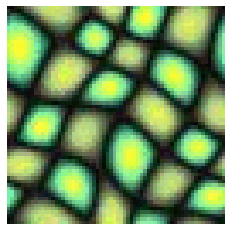

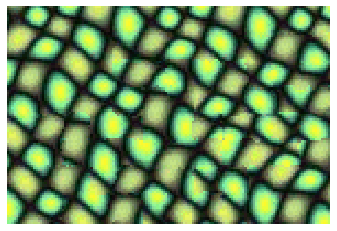

In [13]:
img=np.array(mpimg.imread('../Samples/161.gif')[:,:,:3])
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show()
b=OverlapConstraint(img,15,3,100,150)
plt.imshow(np.uint8(b),cmap='gray')
plt.axis('off')
plt.show()